## Imports and Setup

In [1]:
from datetime import datetime
import sys
import os
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
np.random.seed(42) # for repeatability

## Hidden Regime Setup

In [2]:
# Add the project root to the path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), '..'))

# Import HR Model and Config
import hidden_regime as hr
from hidden_regime.config.model import HMMConfig
from hidden_regime.models.hmm import HiddenMarkovModel as HMM

# Observations
from hidden_regime.config.observation import ObservationConfig
from hidden_regime.observations import BaseObservationGenerator

## Problem Statement

We're going to create a signal that belongs to one of `N_STATES`.

We'll be creating a [Gaussian Mixture](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model) where we randomly switch between the two states as our observed signal.

Note that the centers for the emissions generated by the two states are fairly close together - this is because in most financial predictions we'll be dealing with daily/hourly returns and they are often very small. The tooling in the HMM is designed around those limitations, so we'll be keeping that in mind here as we build our observation set.

In [3]:
NUM_SAMPLES = 200
N_STATES = 2
EXAMPLE_MEAN = 0.2
EXAMPLE_STD = 0.05
NAME = 'ExampleData'

### Create our Example Observation Generator

This is fairly straightforward - we're just using selecting our column (see `NAME` above) from the dataset. There is no special signal or feature generation here.

In [4]:
class ExampleObservationGenerator(BaseObservationGenerator):
    def update(self, data: pd.DataFrame) -> pd.DataFrame:
        # Transform data to observations
        observations = data.copy()
        observations[NAME] = self._compute_feature(data)
        return observations

    def _compute_feature(self, data : pd.DataFrame) -> pd.DataFrame:
        """Compute our observation"""
        return data[NAME]
    
    def plot(self, **kwargs):
        # Visualization logic
        pass

### Add a Visualization Tool

Make it easy + repeatable to plot our states. If we want to plot the values on the same graph, let's do that as well.

In [5]:
def plot_states(states : pd.Series, values : pd.Series = None, obs_mean : float = None, num_samples : int = None) -> List[matplotlib.axes.Axes]:
    """Convenience function for plotting our states"""
    ax = states.plot.line()
    ax.set_yticks(list(range(N_STATES))) 
    ax.set_yticklabels([f'State_{i}' for i in range(N_STATES)])
    ax.set_xlabel('Sample')
    
    if values is not None:
        # Plot our observations
        ax2 = ax.twinx()
        values.plot.line(ax=ax2, color='orange')
        ax2.set_ylabel(values.name)
        
        # Add the state means to the plot to provide context
        state_0_mean = pd.Series(np.array([-obs_mean]*num_samples), name='State_0_Mean')
        state_1_mean = pd.Series(np.array([obs_mean]*num_samples), name='State_1_Mean')
        state_0_mean.plot.line(ax=ax2, linestyle='--', color='r')
        state_1_mean.plot.line(ax=ax2, linestyle='--', color='g')
        
    # Clarify plot information    
    _ = plt.title(states.name)

    if values is not None:
        _ = plt.legend()       

    return [ax] if values is None else [ax, ax2]

### Generate our Observations (Gaussian Mixture)

Algorithm is simple:

1. Decrement our counter. When the counter hits zero, it is time to randomly determine the state and figure out how long we'll be in that state.
2. Generate a sample based on the state. Each of these samples is Gaussian at the given center (`mu`) with a given standard deviation (`std`).
3. Add the sample to our observation set.

What we should see in the data is clear breaks around each state where it is obvious that the observation at time `t` belongs to a state. If we shrink the centers or increase the standard deviations, the mixture will become much more difficult to seperate and the model will struggle.

In [6]:
def generate_observations(
    obs_mean : float, 
    obs_std : float, 
    num_samples : int, 
    obs_name : str) -> Tuple[pd.Series, pd.DataFrame]:    
    """Generate our observations and truth data"""
    
    observationConfig = ObservationConfig(generators=[ExampleObservationGenerator])
    observationGenerator = ExampleObservationGenerator(observationConfig)

    obs = [] # Store our observations
    actual_states = [] # Store our actual states
    state = 0 # Our current state
    count = 0 # How long we've been in a state
    max_time_in_state = int(num_samples/4) # Bound how long we can possibly hang out in a state before drawing again

    for i in range(num_samples):

        # Counter hit zero, re-roll and figure out the state and how long we'll be there
        if count == 0:
            count = np.random.randint(low=2, high=max_time_in_state)
            state = np.random.randint(low=0, high=2)
    
        count -= 1 # Decrement our counter
    
        # Get the parameters for our observation based on the state
        if state == 0: 
            mu = -obs_mean
            std = obs_std
        else:
            mu = obs_mean
            std = obs_std
    
        # Generate the sample at this timestep
        sample = std * np.random.randn() + mu
    
        # Store data
        obs.append(sample)
        actual_states.append(state)

    # Data generation
    actual_states = pd.Series(actual_states, name='ActualStates')
    observations = observationGenerator.update(pd.Series(obs, name=obs_name).to_frame())

    return actual_states, observations

In [7]:
actual_states, observations = generate_observations(
    obs_mean=EXAMPLE_MEAN, 
    obs_std=EXAMPLE_STD, 
    obs_name=NAME, 
    num_samples=NUM_SAMPLES)

### Generate a Histogram of Our Data

We observe a clear separation between signals in this plot.

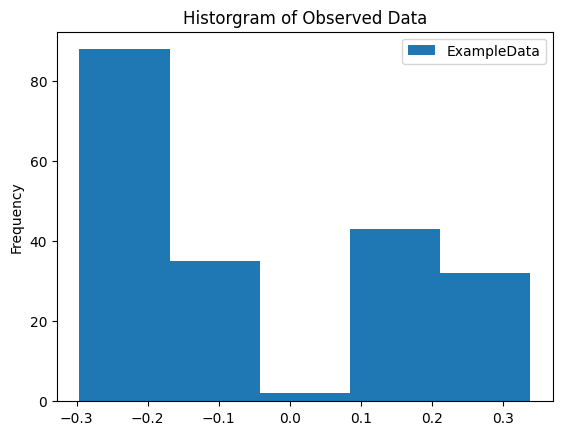

In [8]:
_ = observations.plot.hist(bins=5)
_ = plt.title('Historgram of Observed Data')

### Plot States and Observations

Display our true states and the observed data we'll be feeding to the model.

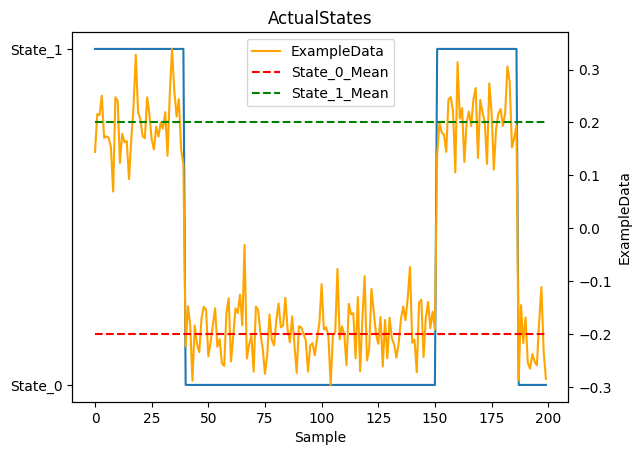

In [9]:
_ = plot_states(actual_states, observations[NAME], obs_mean=EXAMPLE_MEAN, num_samples=NUM_SAMPLES)

### Hidden Markov Model Setup

The `hmm_cfg` object is how we configure our Hidden Markov Model (HMM).

- We specify the **number** of expected states
- We specify **what** we are observing (there may be many, select the one we care about)
- We specify **how** to compute the expected emissions from each state

Computing the model state information is performed in a data-driven approach. We could randomly assign emission characteristics to each state, but that is less than ideal. We could assume some knowledge of how emissions and states relate and assign them manually, but that is cheating ;-P. So we let the data tell us what we should have; we want to understand what a typical emission from each state looks like and using a data-driven approach helps.

We use [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to **initialize** the emission parameters. K-means clusters our observations into N groups, providing initial estimates for the mean and variance of emissions generated by each state. This is just a starting point - Baum-Welch will refine these parameters during training. Note: this approach assumes that each state has a distinct emission profile (which is certainly not always the case in financial markets).

In [10]:
hmm_cfg = HMMConfig(
    n_states=N_STATES, 
    observed_signal=NAME,
    initialization_method='kmeans'
)
hmm = HMM(hmm_cfg)

### Fit the model

Once we have our data and model, we need to fit it to the data. The [Baum-Welch algorithm](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) is used to train the model by estimating the **model parameters** (transition probabilities and emission distribution parameters) that maximize the likelihood of observing our data. It does NOT determine state sequences - that's what the Viterbi algorithm does (used later in `.predict()`). Baum-Welch uses the forward-backward algorithm to iteratively refine the parameters until convergence. In our simple example with well-separated data, it should converge quickly (< 5 iterations).

In [11]:
hmm.fit(observations)

Training on 200 observations (removed 0 NaN values)


### Visualize the Model

Now that we've fit the model, let's understand what it thinks.

`Transition Matrix` tells us how likely state transitions are. Given how separated our data was, this should be very close to the identity matrix. When we repeat this with less separation in our data, this will become less distinct.

- When we have a matrix that is close to the identity, it indicates that the model will tend to remain in a state for a while (not very likely to change). Sidebar - if the transition matrix was truly identity, you would not have any state transitions.
- When we have a more uniformly distributed matrix, it indicates that the states will fluctuate at each time step.

`Emission Parameters` tells us what the model expects each state to produce. 

- `Mean` is the average value we expect from an observation in a given state. It should be close to the `EXAMPLE_MEAN` value above.
- `Std Dev` is the expected spread of an emission from a state (i.e., how a value varies from its mean). It should be close to the `EXAMPLE_STD` value above.

As we noted above, the `Training Convergence` plot is empty - this is expected given that we converged to a solution so quickly.

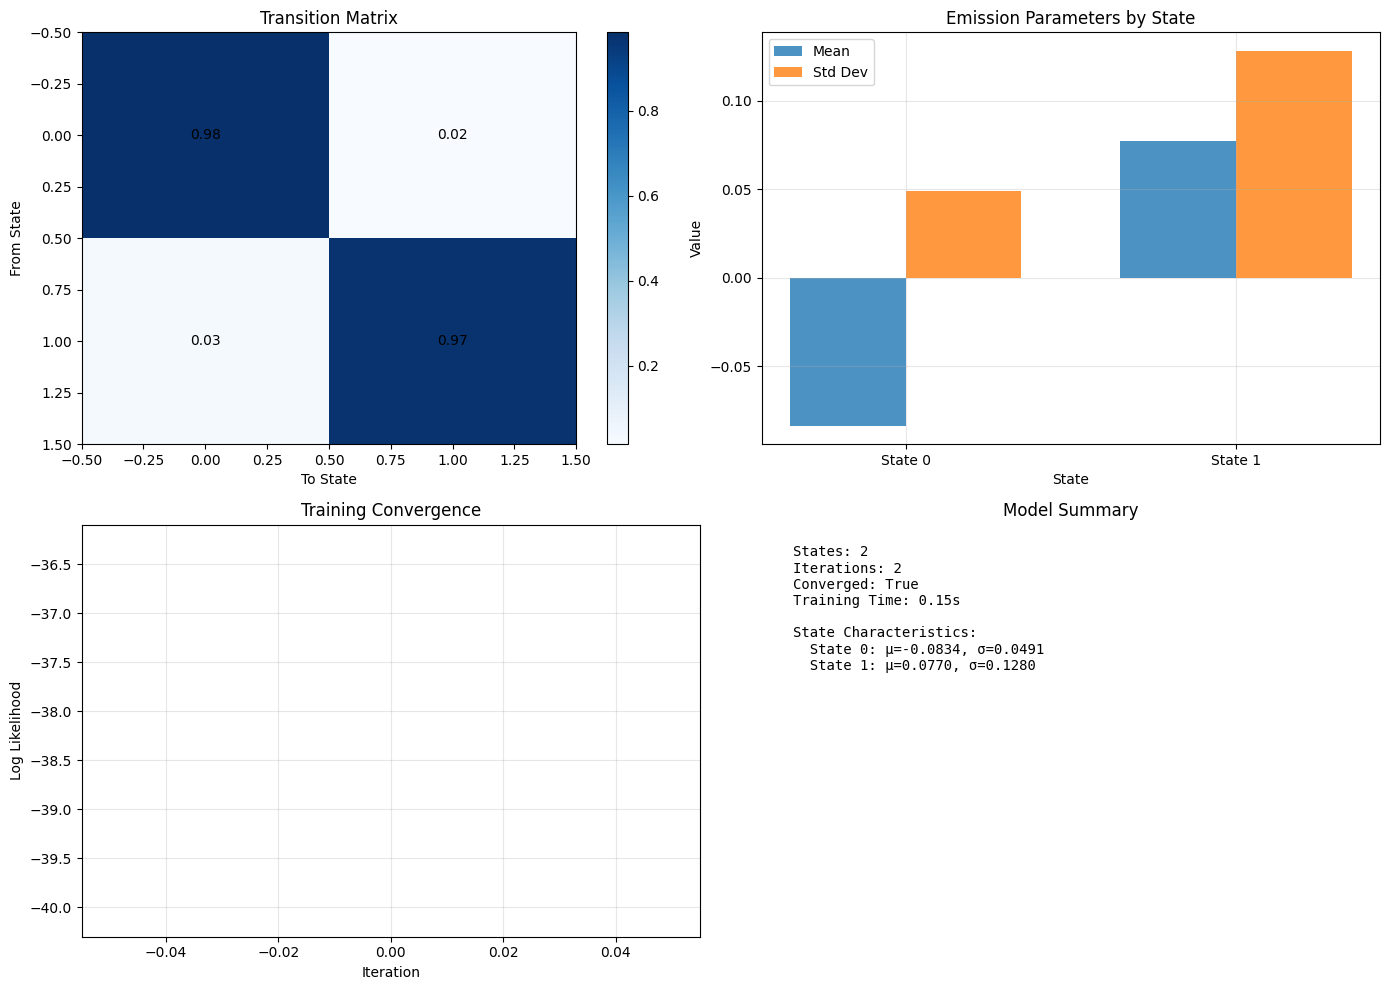

In [12]:
_ = hmm.plot()

### Make Predictions!

Ok, so we fit the model to the data. Let's understand what it thought was happening and compare it to what we know actually happened.

> **Note:** The `.predict()` method uses the **Viterbi algorithm** to find the most likely state sequence given the trained model parameters. This is different from training - Viterbi decodes states, while Baum-Welch estimates parameters.

In [13]:
y = hmm.predict(observations)

### Prediction

As you can see, the model did pretty well! You would _hope_ so, this is a very simple case. Let's try again with something a bit more interesting.

You'll notice the model has some lag when transitioning from `State_1` to `State_0`. This is **expected behavior**, not a bug! Here's why:

The transition matrix is close to **identity** (diagonal values near 1), meaning states tend to persist. When the Viterbi algorithm decodes the state sequence, it performs a Bayesian calculation at each timestep, balancing:

- **Emission evidence**: "Does this observation look like it came from State X?"
- **Transition prior**: "How likely am I to be in State X given where I was before?"

When a true state change occurs, the first few observations after the change are ambiguous - they could plausibly come from either state. The algorithm needs to accumulate **several observations** that consistently favor the new state before the cumulative evidence overcomes the strong prior belief (encoded in the transition matrix) that states persist.

**This is actually a feature!** The lag prevents declaring state changes based on single noisy observations. In financial markets, this is desirable - you don't want to declare a regime change based on one unusual day. The lag provides natural smoothing and robustness to outliers.

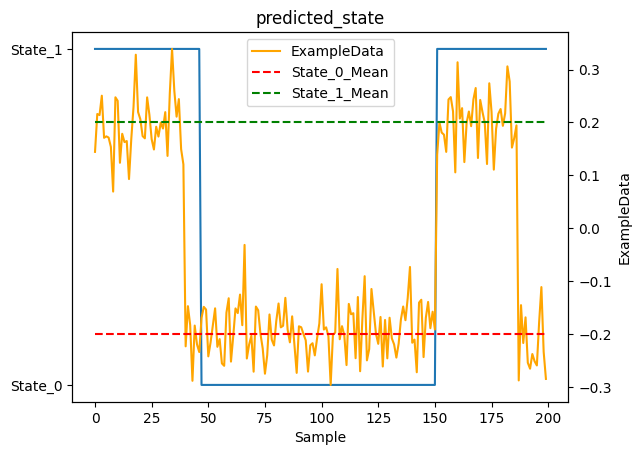

In [14]:
_ = plot_states(y.predicted_state, observations[NAME], obs_mean=EXAMPLE_MEAN, num_samples=NUM_SAMPLES)

In [15]:
score = accuracy_score(actual_states, y.predicted_state)
print(f"Accuracy score: {score:.3%}")

Accuracy score: 90.000%


In [16]:
report = classification_report(actual_states, y.predicted_state)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91       124
           1       0.79      1.00      0.88        76

    accuracy                           0.90       200
   macro avg       0.90      0.92      0.90       200
weighted avg       0.92      0.90      0.90       200



## A More Complicated Problem

Let's make the states less distinct and see how the model performs

In [17]:
NEXT_EXAMPLE_MEAN = 0.05 # Closer centers
NEXT_EXAMPLE_STD = 0.08 # Fatter distribution

In [18]:
next_actual_states, next_observations = generate_observations(
    obs_mean=NEXT_EXAMPLE_MEAN, 
    obs_std=NEXT_EXAMPLE_STD, 
    obs_name=NAME, 
    num_samples=NUM_SAMPLES)

### Updated Observations

There is _much_ less separation between the emissions generated by each of the states in our mixture now. This will be much more challenging for our model.

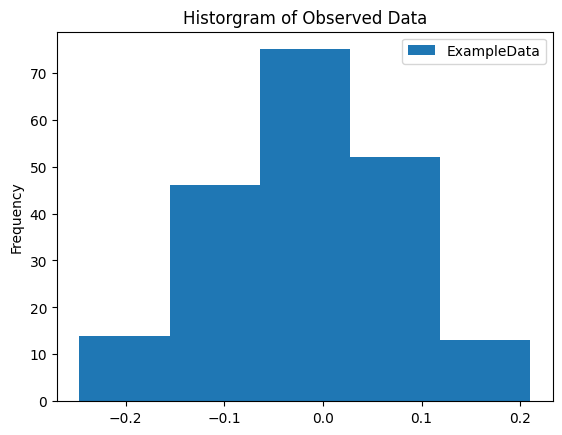

In [19]:
_ = next_observations.plot.hist(bins=5)
_ = plt.title('Historgram of Observed Data')

### Observations

You can see the observations are much less distinct in this picture. There is some slight separation but given the increased variance in the signals it is tough to differentiate visually between the two states.

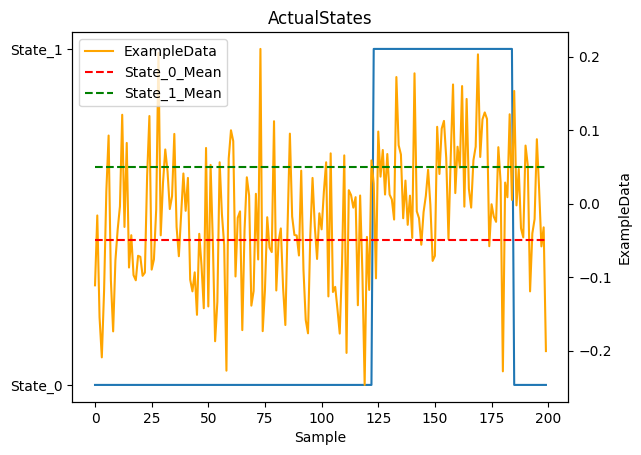

In [20]:
_ = plot_states(next_actual_states, next_observations[NAME], obs_mean=NEXT_EXAMPLE_MEAN, num_samples=NUM_SAMPLES)

### Model Update

Re-train our model on our latest observation set. 

In [21]:
hmm.fit(next_observations)

Training on 200 observations (removed 0 NaN values)


### Training Results

You can see in the `Training Convergence` plot that it took much more effort for the model to become confident in its understanding of the data than the previous example. However, it was able to make reasonable assumptions about states and emission data despite the more "noisy" data.

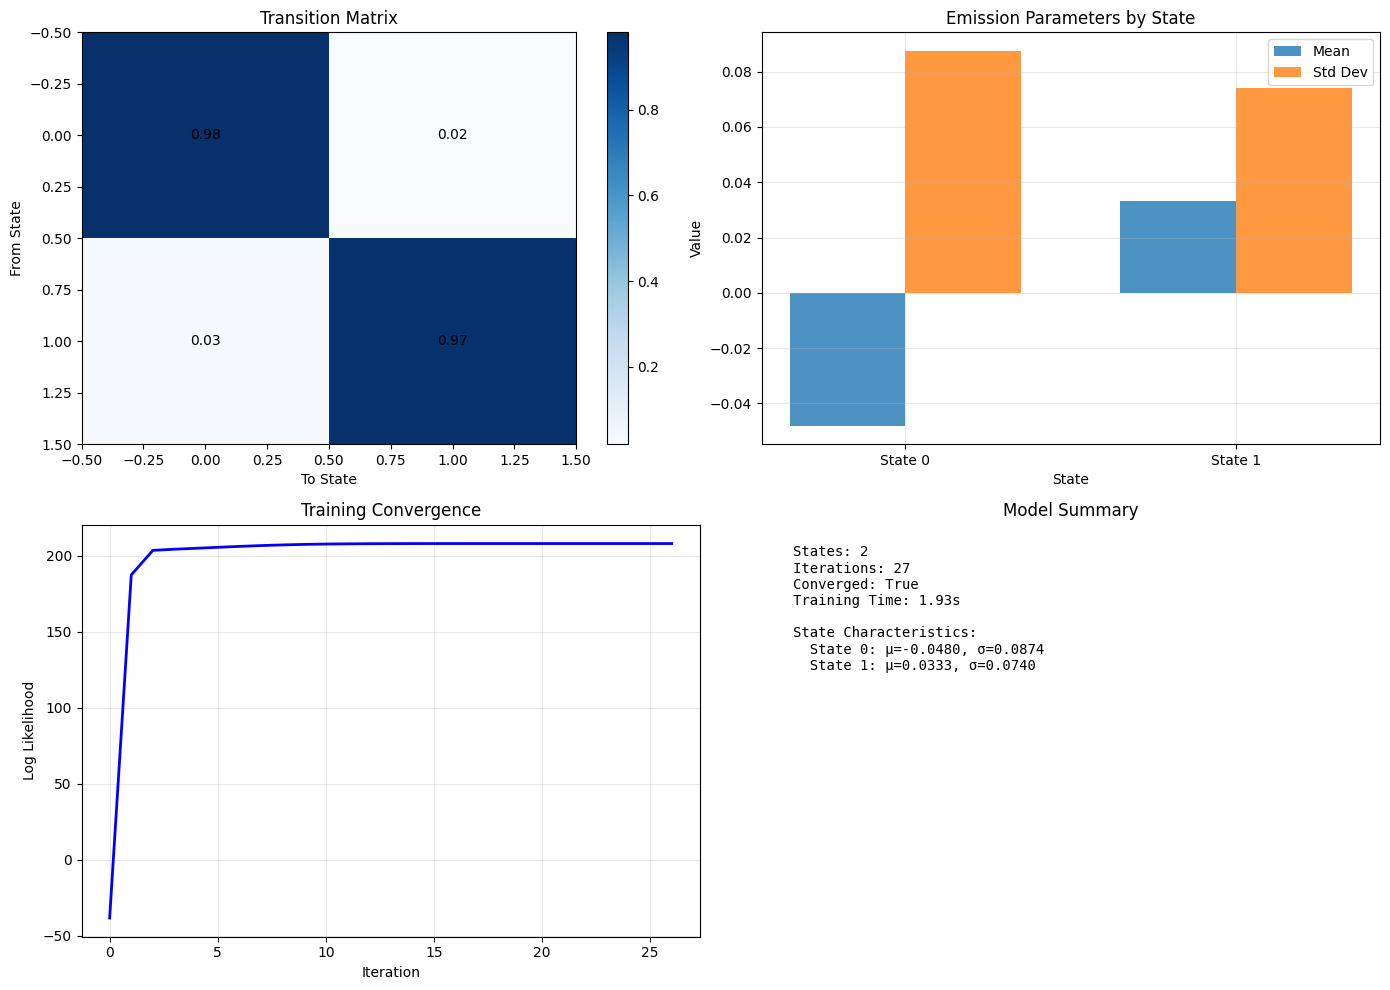

In [22]:
_ = hmm.plot()

### Predictions! 

Let's see how we did given the more much more interesting problem...

In [23]:
y = hmm.predict(next_observations)

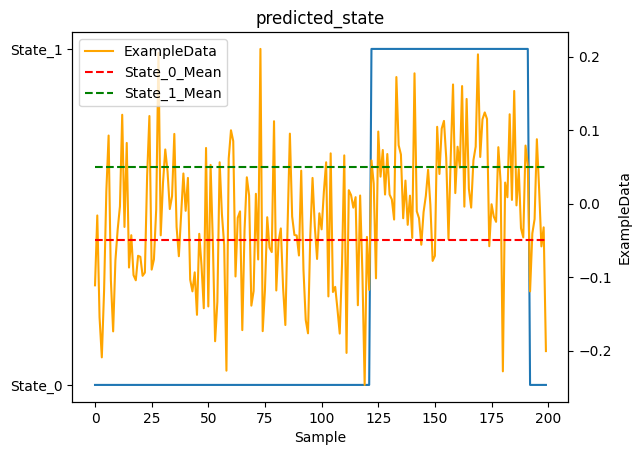

In [24]:
_ = plot_states(y.predicted_state, next_observations[NAME], obs_mean=NEXT_EXAMPLE_MEAN, num_samples=NUM_SAMPLES)

### Analysis

The model was better than a coin-flip. Given the data in this example, that is a pretty good outcome! The observations were generated by the underlying states via their emission distributions, which were not very distinct; you'd be challenged to visually separate the mixture or identify which state produced which observation in this data set.

In [25]:
score = accuracy_score(actual_states, y.predicted_state)
print(f"Accuracy score: {score:.3%}")

Accuracy score: 63.000%


In [26]:
report = classification_report(actual_states, y.predicted_state)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71       124
           1       0.51      0.47      0.49        76

    accuracy                           0.63       200
   macro avg       0.60      0.60      0.60       200
weighted avg       0.62      0.63      0.63       200



## Next Steps

So then, what can we do to improve our model in the face of difficult data?

|Step| Notes| Caution|
|----|------|--------|
|More states| Adding more states to our model can help. |This comes at a price - model outputs are more difficult to interpret, model is more difficult to train. Also correlating emission characteristics to a state will be more challenging.|
|More data| Using more observations can help. |This is not always an option; we can't just get more data from a stock for example.|

We'll work through these in future posts.

Thanks for reading!